In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

import os

from env import get_connection
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

### 1. Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db

In [2]:
url = get_connection("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
food_types_df = df[["Fresh", 'Grocery', 'Frozen']]
food_types_df.head()

,Fresh,Grocery,Frozen
customer_id,,,
0,12669,7561,214
1,7057,9568,1762
2,6353,7684,2405
3,13265,4221,6404
4,22615,7198,3915


In [4]:
# Make the scaler
mms = MinMaxScaler()

#Fit/transform the scaler
food_types_df = mms.fit_transform(food_types_df)

food_types_df

array([[0.11294004, 0.08146416, 0.0031063 ],
       [0.06289903, 0.10309667, 0.02854842],
       [0.05662161, 0.08278992, 0.03911643],
       ...,
       [0.1295431 , 0.32594285, 0.00677142],
       [0.091727  , 0.02402535, 0.01664914],
       [0.02482434, 0.02702178, 0.00065742]])

In [5]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["Fresh", "Grocery", "Frozen" ]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(food_types_df, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [6]:
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Fresh,Scaled_Grocery,Scaled_Frozen
0,2,3,12669,9656,7561,214,2674,1338,0.112940,0.081464,0.003106
1,2,3,7057,9810,9568,1762,3293,1776,0.062899,0.103097,0.028548
2,2,3,6353,8808,7684,2405,3516,7844,0.056622,0.082790,0.039116
3,1,3,13265,1196,4221,6404,507,1788,0.118254,0.045464,0.104842
4,2,3,22615,5410,7198,3915,1777,5185,0.201626,0.077552,0.063934
...,...,...,...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204,0.264829,0.172715,0.215469
436,1,3,39228,1431,764,4510,93,2346,0.349761,0.008202,0.073713
437,2,3,14531,15488,30243,437,14841,1867,0.129543,0.325943,0.006771
438,1,3,10290,1981,2232,1038,168,2125,0.091727,0.024025,0.016649


In [7]:
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(food_types_df)

DBSCAN(eps=0.1, min_samples=20)

In [8]:
df['food_labels'] = dbsc.labels_
df.sample(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Fresh,Scaled_Grocery,Scaled_Frozen,food_labels
107,2,3,8797,10646,14886,2471,8969,1438,0.078414,0.160417,0.040201,0
348,1,3,3428,2380,2028,1341,1184,665,0.030540,0.021827,0.021629,0
416,2,3,4389,10940,10908,848,6728,993,0.039109,0.117540,0.013526,0
289,1,3,42786,286,471,1388,32,22,0.381487,0.005044,0.022402,0
350,1,3,3521,1099,1997,1796,173,995,0.031369,0.021492,0.029107,0


In [9]:
df.food_labels.value_counts()

 0    415
-1     25
Name: food_labels, dtype: int64

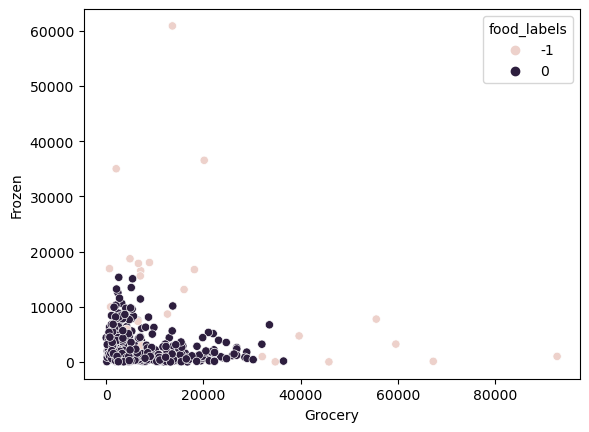

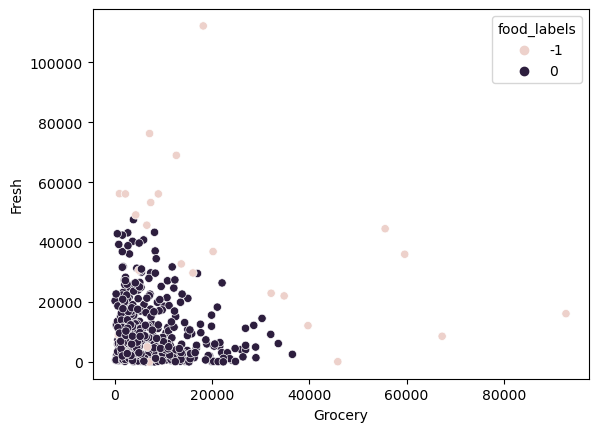

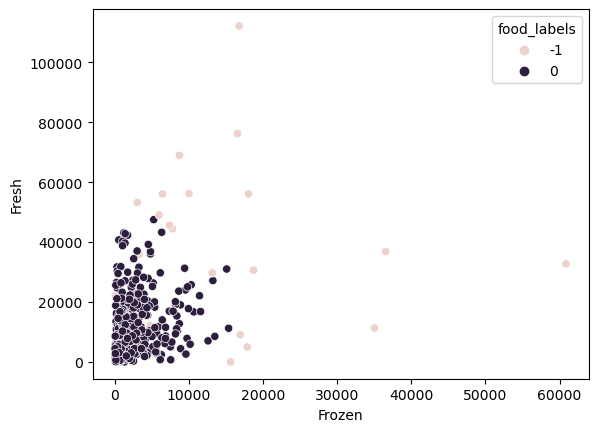

In [10]:
sns.scatterplot(x=df.Grocery, y=df.Frozen, hue=df.food_labels)
plt.show()

sns.scatterplot(x=df.Grocery, y=df.Fresh, hue=df.food_labels)
plt.show()

sns.scatterplot(x=df.Frozen, y=df.Fresh, hue=df.food_labels)
plt.show()

In [11]:
anomalies = df.loc[df['food_labels'] == -1]

In [12]:
anomalies.shape

(25, 12)

In [13]:
anomalies.sample(5)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Fresh,Scaled_Grocery,Scaled_Frozen,food_labels
196,1,1,30624,7209,4897,18711,763,2876,0.273041,0.052750,0.307113,-1
85,2,3,16117,46197,92780,1026,40827,2944,0.143685,1.000000,0.016452,-1
277,1,3,9061,829,683,16919,621,139,0.080768,0.007329,0.277661,-1
86,2,3,22925,73498,32114,987,20070,903,0.204391,0.346109,0.015811,-1
39,1,3,56159,555,902,10002,212,2916,0.500731,0.009690,0.163977,-1


In [14]:
anomalies['Region'].value_counts()

3    18
1     4
2     3
Name: Region, dtype: int64

**Takeaways**

It seems like most outliers or anomalies are coming from region number 3. We only have aboue 25 from in our anomaliy cluster.

### 2. Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database

In [15]:
if os.path.isfile('curriculum_logs.csv'):
    
    df = pd.read_csv('curriculum_logs.csv')
    
else:
    url = get_connection('curriculum_logs')
    
    query = '''
            SELECT *
            FROM logs
            '''
    
    df = pd.read_sql(query, url)

In [16]:
df.drop(columns = 'Unnamed: 0', inplace = True)

In [17]:
df

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...,...
900218,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33
900219,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33
900220,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33
900221,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86


In [18]:
df.isna().sum()

date             0
time             0
path             1
user_id          0
cohort_id    52893
ip               0
dtype: int64

In [19]:
df.dtypes

date          object
time          object
path          object
user_id        int64
cohort_id    float64
ip            object
dtype: object

In [20]:
ip_df = df[["date", 'time']]
ip_df.head()

,date,time
0,2018-01-26,09:55:03
1,2018-01-26,09:56:02
2,2018-01-26,09:56:05
3,2018-01-26,09:56:06
4,2018-01-26,09:56:24


In [21]:
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(ip_df)

ValueError: could not convert string to float: '2018-01-26'

### 3. Use DBSCAN to detect anomalies in wine dataset

In [22]:
df = pd.read_csv('wines.csv')

In [23]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


In [24]:
wine_df = df[["fixed acidity", 'pH', 'alcohol']]
wine_df.head()

,fixed acidity,pH,alcohol
0,7.4,3.51,9.4
1,7.8,3.20,9.8
2,7.8,3.26,9.8
3,11.2,3.16,9.8
4,7.4,3.51,9.4


In [25]:
# Make the scaler
mms = MinMaxScaler()

#Fit/transform the scaler
wine_df = mms.fit_transform(wine_df)

wine_df

array([[0.29752066, 0.6124031 , 0.20289855],
       [0.33057851, 0.37209302, 0.26086957],
       [0.33057851, 0.41860465, 0.26086957],
       ...,
       [0.2231405 , 0.20930233, 0.20289855],
       [0.14049587, 0.48062016, 0.69565217],
       [0.18181818, 0.41860465, 0.55072464]])

In [26]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["fixed acidity", "pH", "alcohol" ]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(wine_df, columns=scaled_columns)

In [29]:
scaled_df

,Scaled_fixed acidity,Scaled_pH,Scaled_alcohol
0,0.297521,0.612403,0.202899
1,0.330579,0.372093,0.260870
2,0.330579,0.418605,0.260870
3,0.611570,0.341085,0.260870
4,0.297521,0.612403,0.202899
...,...,...,...
6492,0.198347,0.426357,0.463768
6493,0.231405,0.333333,0.231884
6494,0.223140,0.209302,0.202899
6495,0.140496,0.480620,0.695652


In [43]:
df.reset_index().drop(columns='index', inplace = True)

In [44]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


In [47]:
# Merge the scaled and non-scaled values into one dataframe
df = pd.merge(df, scaled_df, left_index=True, right_index=True)

In [48]:
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,Scaled_fixed acidity,Scaled_pH,Scaled_alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red,0.297521,0.612403,0.202899
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red,0.330579,0.372093,0.260870
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red,0.330579,0.418605,0.260870
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red,0.611570,0.341085,0.260870
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red,0.297521,0.612403,0.202899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white,0.198347,0.426357,0.463768
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white,0.231405,0.333333,0.231884
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white,0.223140,0.209302,0.202899
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white,0.140496,0.480620,0.695652


In [49]:
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(wine_df)

DBSCAN(eps=0.1, min_samples=20)

In [50]:
df['wine_labels'] = dbsc.labels_

In [51]:
df.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,Scaled_fixed acidity,Scaled_pH,Scaled_alcohol,wine_labels
3930,7.5,0.30,0.32,1.4,0.032,31.0,161.0,0.99154,2.95,0.42,10.5,5,white,0.305785,0.178295,0.362319,0
10,6.7,0.58,0.08,1.8,0.097,15.0,65.0,0.99590,3.28,0.54,9.2,5,red,0.239669,0.434109,0.173913,0
5377,6.3,0.15,0.30,1.4,0.022,38.0,100.0,0.99099,3.42,0.57,11.4,7,white,0.206612,0.542636,0.492754,0
2116,7.4,0.15,0.42,1.7,0.045,49.0,154.0,0.99200,3.00,0.60,10.4,6,white,0.297521,0.217054,0.347826,0
98,7.6,0.90,0.06,2.5,0.079,5.0,10.0,0.99670,3.39,0.56,9.8,5,red,0.314050,0.519380,0.260870,0


In [52]:
df.wine_labels.value_counts()

 0    6443
-1      54
Name: wine_labels, dtype: int64

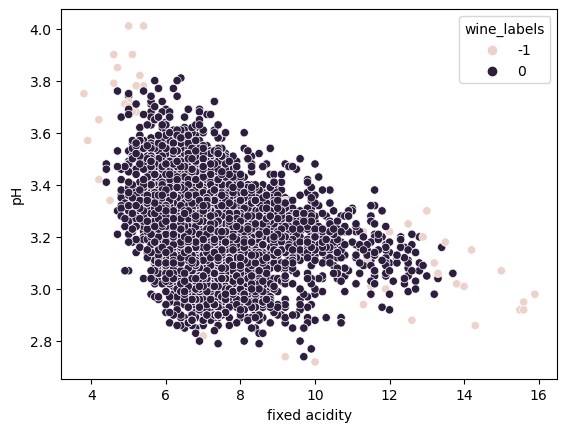

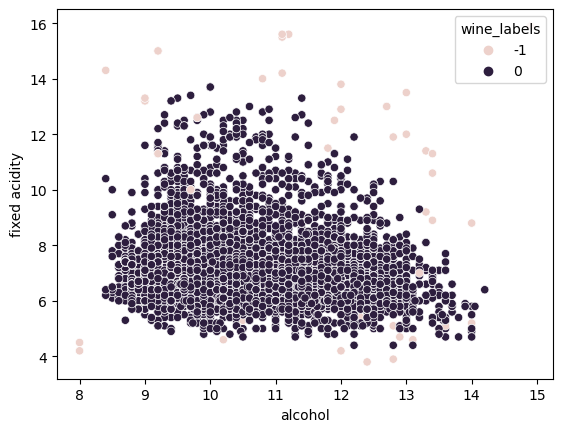

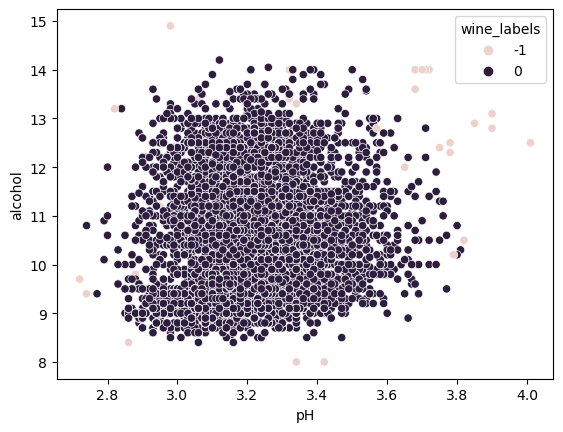

In [54]:
sns.scatterplot(x=df['fixed acidity'], y=df.pH, hue=df.wine_labels)
plt.show()

sns.scatterplot(x=df.alcohol, y=df['fixed acidity'], hue=df.wine_labels)
plt.show()

sns.scatterplot(x=df.pH, y=df.alcohol, hue=df.wine_labels)
plt.show()

In [55]:
anomalies = df.loc[df['wine_labels'] == -1]

In [58]:
anomalies.shape

(54, 17)

In [59]:
anomalies.sample(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,Scaled_fixed acidity,Scaled_pH,Scaled_alcohol,wine_labels
243,15.0,0.21,0.44,2.2,0.075,10.0,24.0,1.00005,3.07,0.84,9.2,7,red,0.925620,0.271318,0.173913,-1
395,12.0,0.37,0.76,4.2,0.066,7.0,38.0,1.00040,3.22,0.60,13.0,7,red,0.677686,0.387597,0.724638,-1
1270,5.0,0.38,0.01,1.6,0.048,26.0,60.0,0.99084,3.70,0.75,14.0,6,red,0.099174,0.759690,0.869565,-1
484,10.6,0.44,0.68,4.1,0.114,6.0,24.0,0.99700,3.06,0.66,13.4,6,red,0.561983,0.263566,0.782609,-1
244,15.0,0.21,0.44,2.2,0.075,10.0,24.0,1.00005,3.07,0.84,9.2,7,red,0.925620,0.271318,0.173913,-1


In [60]:
anomalies['type'].value_counts()

red      44
white    10
Name: type, dtype: int64

**Takeaways**

 - It seems like out of the 54 anomalies we got from our clustering we find the about 80% of them are red type of wines and the remaining white.